In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout1D
from sklearn.model_selection import train_test_split
from glob import glob
import tensorflow as tf
from sklearn import preprocessing as prprsng
from tqdm import tqdm
from keras.utils import np_utils



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove6b300dtxt/glove.6B.300d.txt
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/hni-legend-cleaned-data/cleaned_train_incident.csv
/kaggle/input/hni-legend-cleaned-data/cleaned_test_incident.csv


In [2]:
train = pd.read_csv('../input/hni-legend-cleaned-data/cleaned_train_incident.csv')
test = pd.read_csv('../input/hni-legend-cleaned-data/cleaned_test_incident.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**importing self-attention form keras**

In [3]:
# https://pypi.org/project/keras-self-attention/
# pip install keras-self-attention

# import sys
# sys.path.insert(0, '../input/attention')
# from keras_self_attention import SeqSelfAttention

**Defining attention layer manually**

In [4]:
from keras.layers import *
from keras.models import *
from keras import backend as K

In [5]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [6]:
# class attention(Layer):
#     def __init__(self,return_sequences=True):
#         self.return_sequences = return_sequences
#         super(attention,self).__init__()

#     def build(self,input_shape):
#         self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
#         self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
#         super(attention, self).build(input_shape)

#     def call(self,x):
#         et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
#         at=K.softmax(et)
#         at=K.expand_dims(at,axis=-1)
#         output=x*at
#         if self.return_sequences:
#             return output
#         return K.sum(output,axis=1)

#     def compute_output_shape(self,input_shape):
#         return (input_shape[0],input_shape[-1])

#     def get_config(self):
#         return super(attention,self).get_config()

In [7]:
# class attention(Layer):
#     def __init__(self,return_sequences=True):
#         self.return_sequences = return_sequences
#         super(attention,self).__init__()

#     def build(self,input_shape):
#         self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
#         self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
#         super(attention,self).build(input_shape)

#     def call(self,x):
#         e = K.tanh(K.dot(x,self.W)+self.b)
#         a = K.softmax(e, axis=1)
#         output = x*a
#         if self.return_sequences:
#             return output
#         return K.sum(output, axis=1)

**Merging CSVs**

In [8]:
data_files = sorted(glob('../input/hni-legend-cleaned-data/*.csv'))
merged_data = pd.concat(pd.read_csv(datafile) for datafile in data_files)
merged_data.dropna(how='any', subset=['processed','legend_cluster'],inplace=True)
merged_data = merged_data[['processed','legend_cluster']]

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/concat.py:348: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  objs = list(objs)


In [9]:
# merged_data.info()
# merged_data.legend_cluster.value_counts()

# merged_data
# merged_data.describe()
# merged_data.isnull().sum()

In [10]:
X=merged_data.drop('legend_cluster',axis=1)
y = merged_data['legend_cluster']

In [11]:
label_encoder = prprsng.LabelEncoder()
labels = label_encoder.fit_transform(merged_data.legend_cluster.values)
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(merged_data.processed.values, labels, 
 stratify=y, 
 random_state=42, 
 test_size=0.2, shuffle=True)

In [13]:
#GloVe

glove_dir='../input/glove6b300dtxt/glove.6B.300d.txt'

embeddings_index = {}
f = open(glove_dir, encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [14]:
VOCABULARY_SIZE = 20000
MAX_LENGTH = 60

In [15]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(xtrain) + list(xtest))

In [16]:
xtrain_sequence = tokenizer.texts_to_sequences(xtrain)
xtest_sequence = tokenizer.texts_to_sequences(xtest)

In [17]:
xtrain_padding = sequence.pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)
xtest_padding = sequence.pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)
word_index = tokenizer.word_index

In [18]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 76052/76052 [00:00<00:00, 361755.16it/s]


In [19]:
# model = Sequential()
# model.add(Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=False))
# model.add(SpatialDropout1D(0.3))
# model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.8))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.8))
# model.add(Dense(15))
# # model.add(SeqSelfAttention(return_sequences=True))
# model.add(attention())
# model.add(Activation('softmax'))
# model.add(tf.keras.layers.Flatten())
# model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# model.summary()

In [20]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.8))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.8))
# model.add(Dense(15))
# model.add(SeqSelfAttention(return_sequences=True))
#model.add(attention(return_sequences=True))
model.add(attention())
model.add(Dropout(0.5))
# model.add(Activation('softmax'))
# model.add(tf.keras.layers.Flatten())
model.add(Dense(15, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-05-24 15:56:54.274946: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 300)           22815900  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           320800    
_________________________________________________________________
attention (attention)        (None, 200)               260       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 15)                3015      
Total params: 23,139,975
Trainable params: 324,075
Non-trainable params: 22,815,900
______________________________________

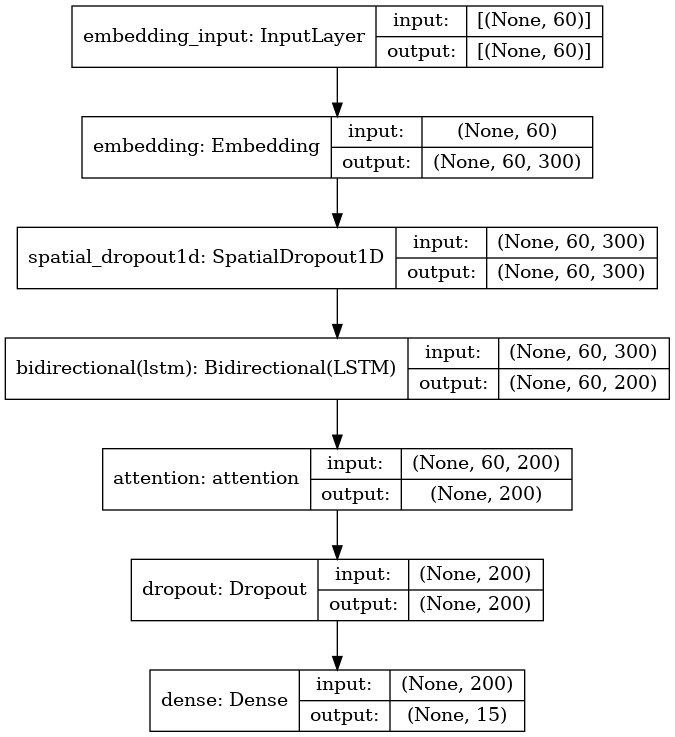

In [21]:
import keras
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [22]:
ytrain_encode = np_utils.to_categorical(ytrain)
ytest_encode = np_utils.to_categorical(ytest)

In [23]:
history = model.fit(xtrain_padding, y=ytrain_encode, batch_size=512, epochs=3, verbose=1, validation_data=(xtest_padding, ytest_encode))

2022-05-24 15:56:56.425568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
405/405 [==============================] - 769s 2s/step - loss: 1.2582 - accuracy: 0.6007 - val_loss: 0.8969 - val_accuracy: 0.6997
Epoch 2/3
405/405 [==============================] - 766s 2s/step - loss: 0.9284 - accuracy: 0.6906 - val_loss: 0.8166 - val_accuracy: 0.7262
Epoch 3/3
405/405 [==============================] - 753s 2s/step - loss: 0.8607 - accuracy: 0.7108 - val_loss: 0.7787 - val_accuracy: 0.7377


In [24]:
# predictions = (model.predict(xtest_padding) > 0.5).astype("int32")

In [25]:
predictions = model.predict(xtest_padding)
encoded_prediction=np.argmax(predictions, axis=1)
encoded_gt=np.argmax(ytest_encode, axis=1)
#print(labels[encoded_prediction])

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(encoded_gt,encoded_prediction)

0.7376944755433733

In [27]:
from sklearn.metrics import classification_report
print(classification_report(encoded_gt,encoded_prediction))

              precision    recall  f1-score   support

           0       0.65      0.49      0.56      1193
           1       0.71      0.86      0.78      1176
           2       0.60      0.54      0.57       927
           3       0.92      0.71      0.80      2420
           4       0.98      0.97      0.98      7262
           5       0.55      0.54      0.55      3033
           6       0.51      0.22      0.31      1026
           7       0.71      0.83      0.77      1728
           8       0.71      0.77      0.74     13244
           9       0.51      0.38      0.44      1045
          10       0.60      0.49      0.54      1019
          11       0.93      0.92      0.92      1399
          12       0.75      0.81      0.78      2641
          13       0.94      0.92      0.93      4462
          14       0.57      0.59      0.58      9231

    accuracy                           0.74     51806
   macro avg       0.71      0.67      0.68     51806
weighted avg       0.74   